In [1]:
"""
Debug gclm2lenmap
"""
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import pysht
import sys
from time import process_time

from delensalot.sims.sims_lib import Xunl, Xsky
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

runinfos = [
    # ("CPU", "lenspyx", 'ducc'),
    ("CPU", "duccnufft", 'ducc'),
    ("GPU", "cufinufft", 'shtns')
    ]

lmaxs = [1023]
phi_lmaxs = [lmax+256 for lmax in lmaxs]
defres = {}
Tsky = None
Tsky2 = None
for lmax, phi_lmax in zip(lmaxs, phi_lmaxs):
    geominfo = ('gl',{'lmax':lmax})
    lenjob_geominfo = ('gl',{'lmax':phi_lmax})
    lldlm = np.arange(0,phi_lmax+1)
    synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=phi_lmax)
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo, epsilon=1e-10)
    philm = synunl.get_sim_phi(0, space='alm')
    toydlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))
    toyunllm = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
    Tsky2 = synsky.unl2len(toyunllm, philm, spin=0)
    # toyunllm = (np.random.random(size=hp.Alm.getsize(lmax, lmax)) +  np.random.random(size=hp.Alm.getsize(lmax, lmax))*1j)*1e-6
    # toydlm = (np.random.random(size=hp.Alm.getsize(lmax, lmax)) +  np.random.random(size=hp.Alm.getsize(lmax, lmax))*1j)*1e-6
    for runinfo in runinfos:
        kwargs = {
            'geominfo': geominfo,
            'nthreads': 10,
            'epsilon': 1e-10,
            'verbosity': 0,
            'planned': False,
            'single_prec': False,
            'shttransformer_desc': runinfo[2]
        }
        
        deflection_kwargs = {
            'dlm': toydlm,
            'mmax_dlm': phi_lmax,
            'epsilon': 1e-10,
            'verbosity': 0,  
            'single_prec': False,
            'nthreads': 10,
            'geominfo': lenjob_geominfo,
        }    
        print(runinfo)
        backend = runinfo[0]
        defres.update({backend: {}}) if backend not in defres.keys() else None
        solver = runinfo[1]
        defres[backend].update({solver : None}) if solver not in defres[backend].keys() else None
        for mode in ['nuFFT']:
            print("\nTesting:: solver = {} backend = {} mode = {} ...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(**kwargs, deflection_kwargs=deflection_kwargs)
            print("\n----lmax: {}, phi_lmax: {}, dlm_lmax = {}, epsilon: {}----".format(lmax, phi_lmax, hp.Alm.getlmax(toydlm.size), deflection_kwargs['epsilon']))
            if backend == 'CPU':
                if solver == 'lenspyx':
                    defres[backend][solver] = t.gclm2lenmap(
                            toyunllm.copy(), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug', ptg=None)
                else:
                    defres[backend][solver] = t.gclm2lenmap(
                            toyunllm.copy(), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug')
            elif backend == 'GPU':
                defres[backend][solver] = t.gclm2lenmap(toyunllm.copy(), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug')
                
print(defres['CPU'].keys())

[SHTns 3.6.6] built Apr  8 2024, 07:59:49, id: v3.6.6-10-g3986338*,avx512,ishioka,openmp,cuda
mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
INFO:: 04-22 18:17:54:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-22 18:17:54:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 04-22 18:17:54:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-22 18:17:54:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
1024 1024 1024 1024
inside _build_d1
lmax_dlm:  1279
mmax_dlm:  1279
----
shape d1:  (2, 2097152)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shape d1:  (2, 2097152)
lmax_dlm:  1279
mmax_dlm:  1279
shapes:  (1024,) (1024,) (1024,) (1024,) (2, 2097152)
(2097152, 3)
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(2097152,)

/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/cufinufft/_plan.py:336: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the "


## Only for lenpsyx

ValueError: operands could not be broadcast together with shapes (2097152,) (1,3276800) 

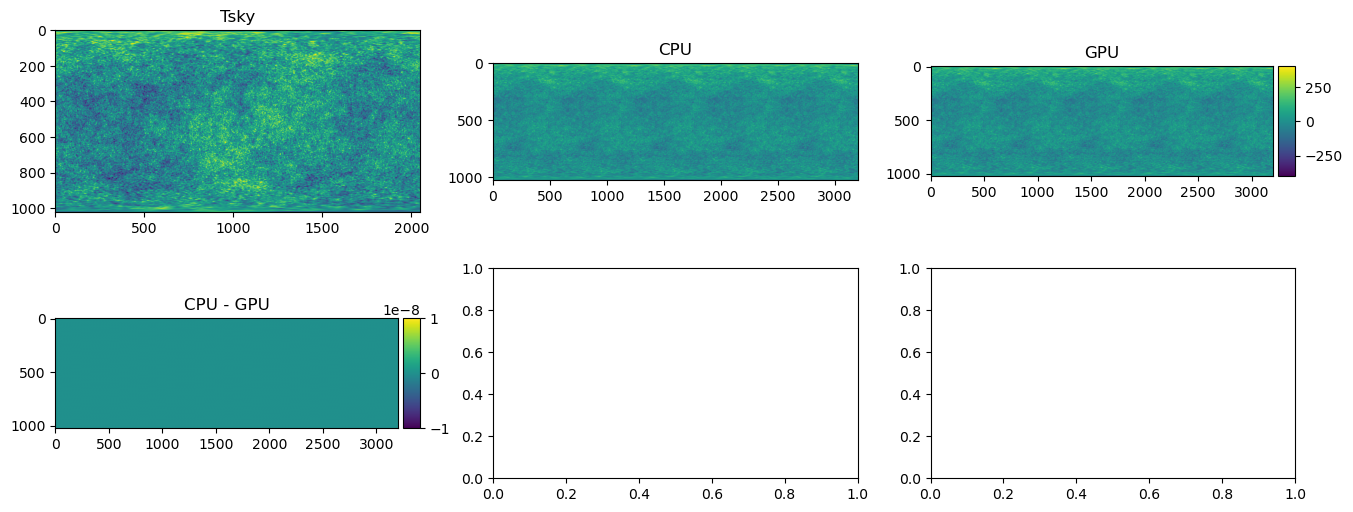

In [4]:
keyGPU = 'nuFFT'
keyCPU = 'synthesisgeneral'
# Tsky = Tsky2

vmin, vmax = -4e2, 4e2
resCPU = defres['CPU']['lenspyx'][keyCPU].real
resGPU = resCPU #defres['GPU'][keyGPU][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(((resCPU-resGPU).reshape(lmax+1,-1)), vmin=-1e-8, vmax=1e-8)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=-1e-5, vmax=1e-5)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(2, 2097152) (1, 2097152, 2)


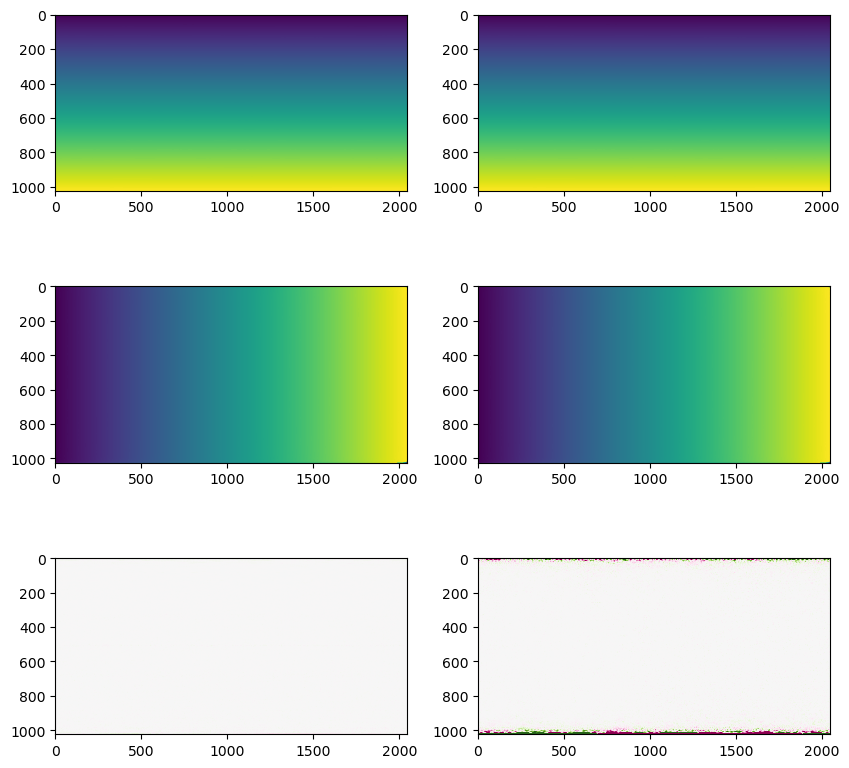

In [10]:
keyGPU = 'dlm2pointing'
keyCPU = 'pointing'
solverCPU, solverGPU = 'lenspyx', 'duccnufft'

print(defres['CPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['CPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['CPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1) - defres['CPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1) - defres['CPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

(2, 2097152) (1, 2097152, 2)


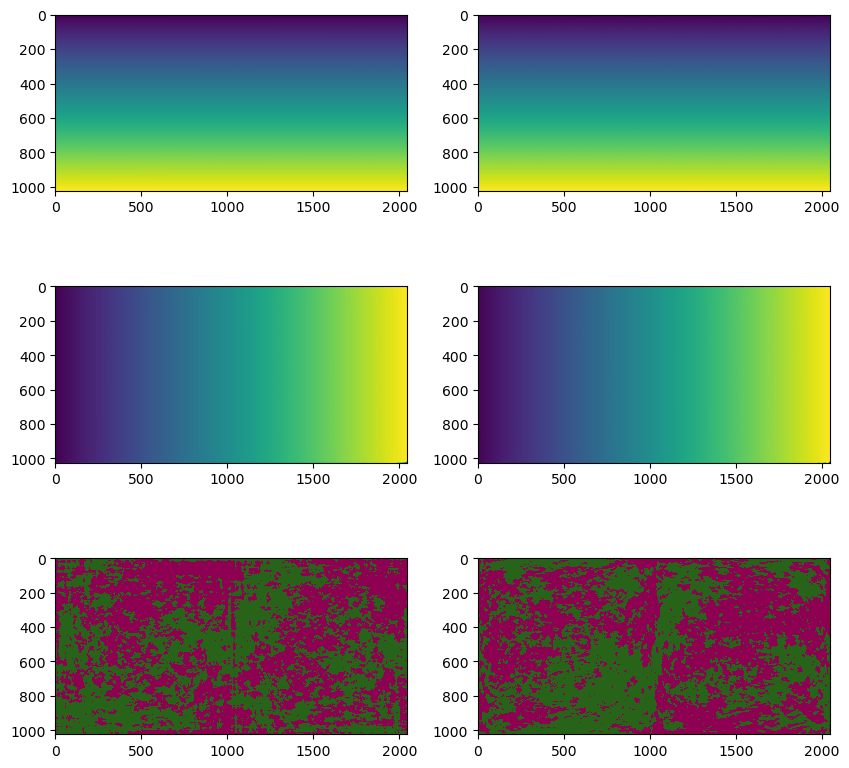

In [8]:
keyGPU = 'dlm2pointing'
keyCPU = 'pointing'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'

print(defres['GPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

In [2]:
defres['CPU'].keys()

dict_keys(['duccnufft'])

# all others

### pointing things

(2, 3276800) (2, 3276800)


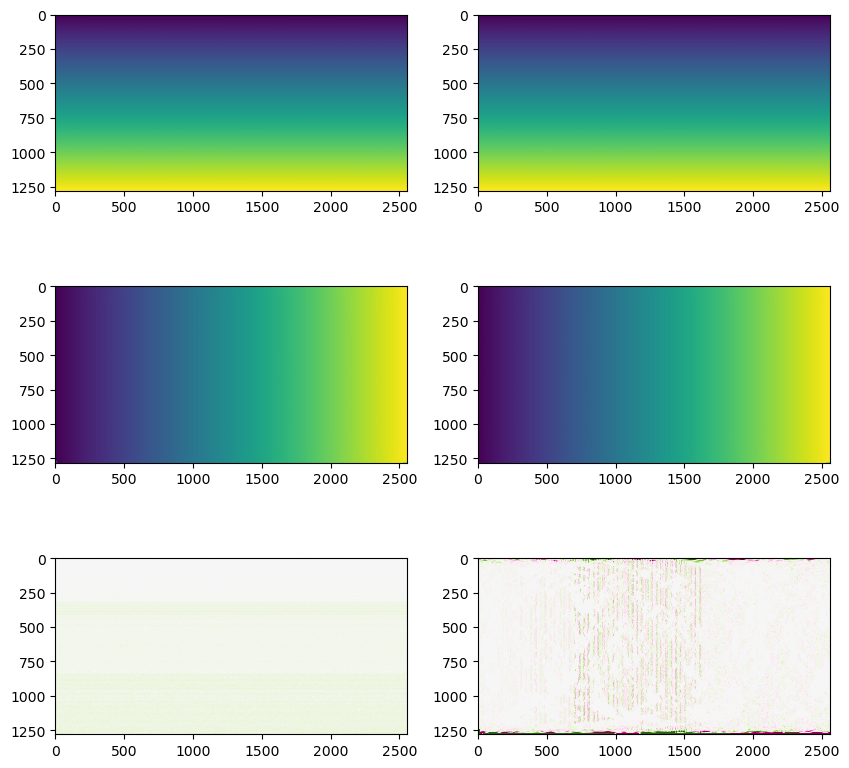

In [6]:
key = 'dlm2pointing'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
vmin, vmax = -1e-15, 1e-15
fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)
ax[2,1].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)

## synthesis general

(1032, 2048)


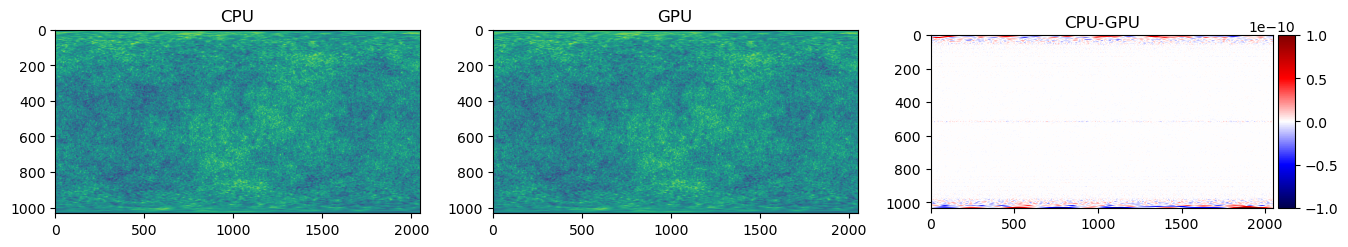

In [7]:
key = 'synthesis'
vmin=-1e-10
vmax=1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][solverCPU][key][0][0].shape)

ax[0].imshow(defres['CPU'][solverCPU][key][0][0])
ax[0].set_title('CPU')

ax[1].imshow(defres['GPU'][solverGPU][key][0].reshape(t.constructor.nphi,-1).T)
ax[1].set_title('GPU')

im = ax[2].imshow(defres['CPU'][solverCPU][key][0][0]-defres['GPU'][solverGPU][key][0].reshape(t.constructor.nphi,-1).T, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(2062, 2048) (4222976,)


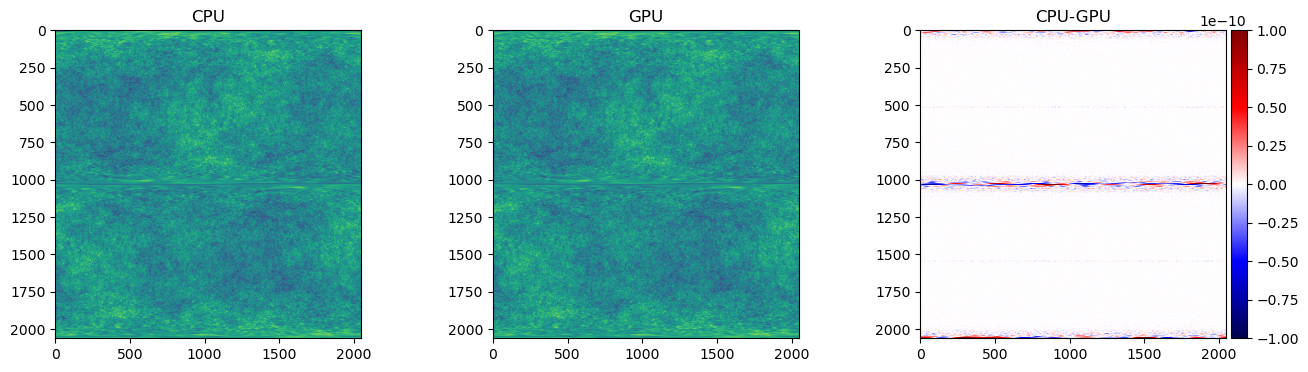

In [8]:
key = 'doubling'
vmin=-1e-10
vmax=1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][solverCPU][key][0].shape, defres['GPU'][solverGPU][key][0].shape)

ax[0].imshow(defres['CPU'][solverCPU][key][0])
ax[0].set_title('CPU')

ax[1].imshow(defres['GPU'][solverGPU][key][0].reshape(-1,t.constructor.nphi))
ax[1].set_title('GPU')

im = ax[2].imshow(defres['CPU'][solverCPU][key][0]-defres['GPU'][solverGPU][key][0].reshape(-1,t.constructor.nphi), cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(1, 2048, 2062) (1, 2062, 2048)


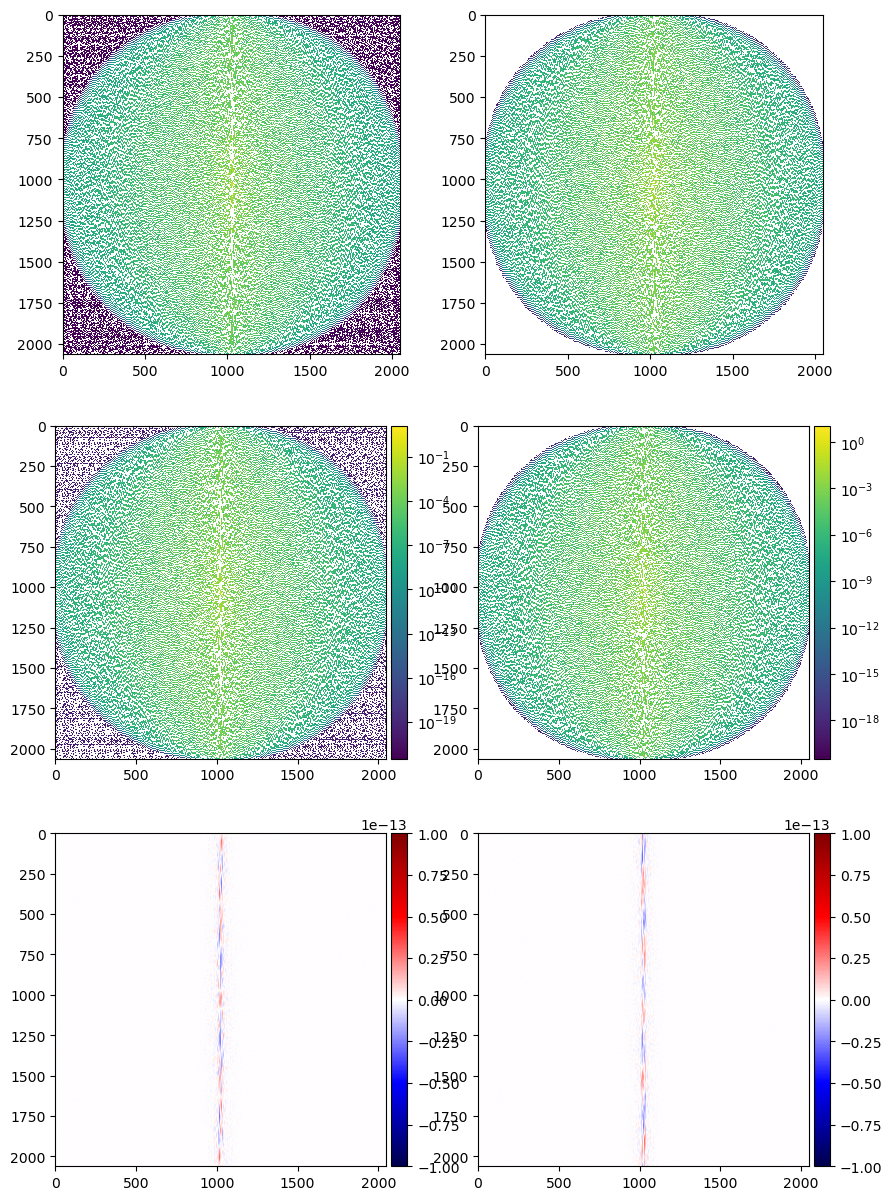

In [9]:
key = 'C2C'
vmin=-1e-13
vmax=1e-13

print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)

fig, ax = plt.subplots(3,2, figsize=(10,15))

ax[0,0].imshow(np.real(np.fft.fftshift(defres['CPU'][solverCPU][key][0],axes=(0,1))), norm='log')
ax[0,1].imshow(np.imag(np.fft.fftshift(defres['CPU'][solverCPU][key][0],axes=(0,1))), norm='log')

im = ax[1,0].imshow(np.real(np.fft.fftshift(defres['GPU'][solverGPU][key][0].reshape(2*(lmax+1),-1).T,axes=(0,1))), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(np.fft.fftshift(defres['GPU'][solverGPU][key][0].reshape(2*(lmax+1),-1).T,axes=(0,1))), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,0].imshow(np.real(np.fft.fftshift(defres['CPU'][solverCPU][key][0]-defres['GPU'][solverGPU][key][0].reshape(2*(lmax+1),-1).T,axes=(0,1))), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(np.imag(np.fft.fftshift(defres['CPU'][solverCPU][key][0]-defres['GPU'][solverGPU][key][0].reshape(2*(lmax+1),-1).T,axes=(0,1))), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ValueError: operands could not be broadcast together with shapes (2097152,) (1,3276800) 

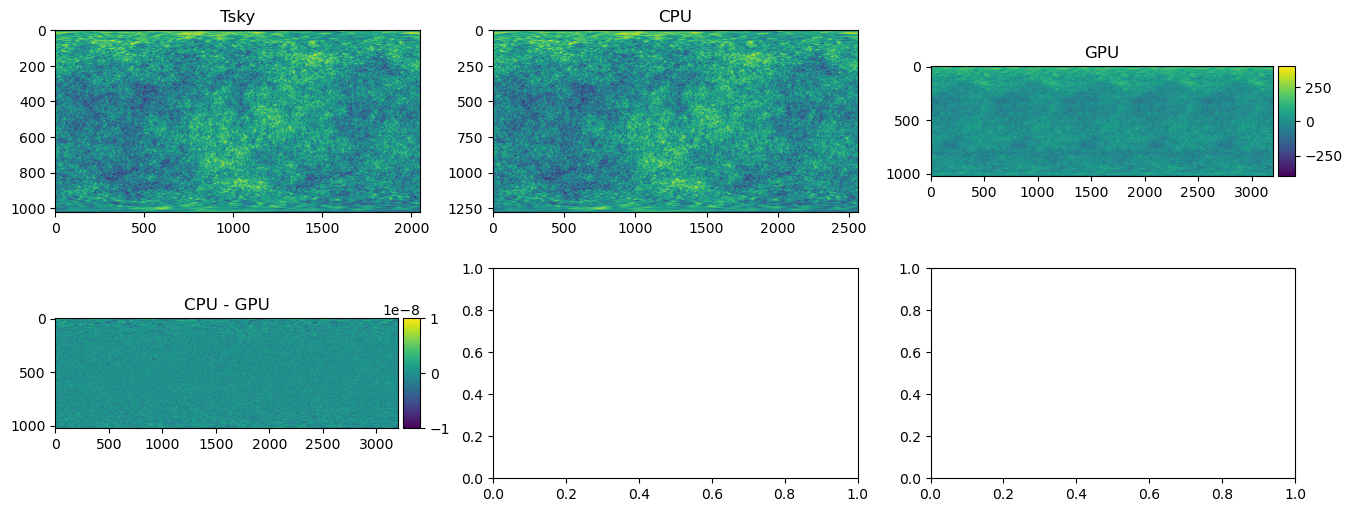

In [11]:
key = 'nuFFT'
Tsky = Tsky2
resCPU = defres['CPU'][solverCPU][key].real
vmin, vmax = -4e2, 4e2
resCPU = defres['CPU'][solverCPU][key].real
resGPU = defres['GPU'][solverGPU][key][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1).real, vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(phi_lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow((resCPU-resGPU).reshape(lmax+1,-1), vmin=-1e-8, vmax=1e-8)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

vmin, vmax = -1e-7, 1e-7
im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


"""differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'
"""

"differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'\n"

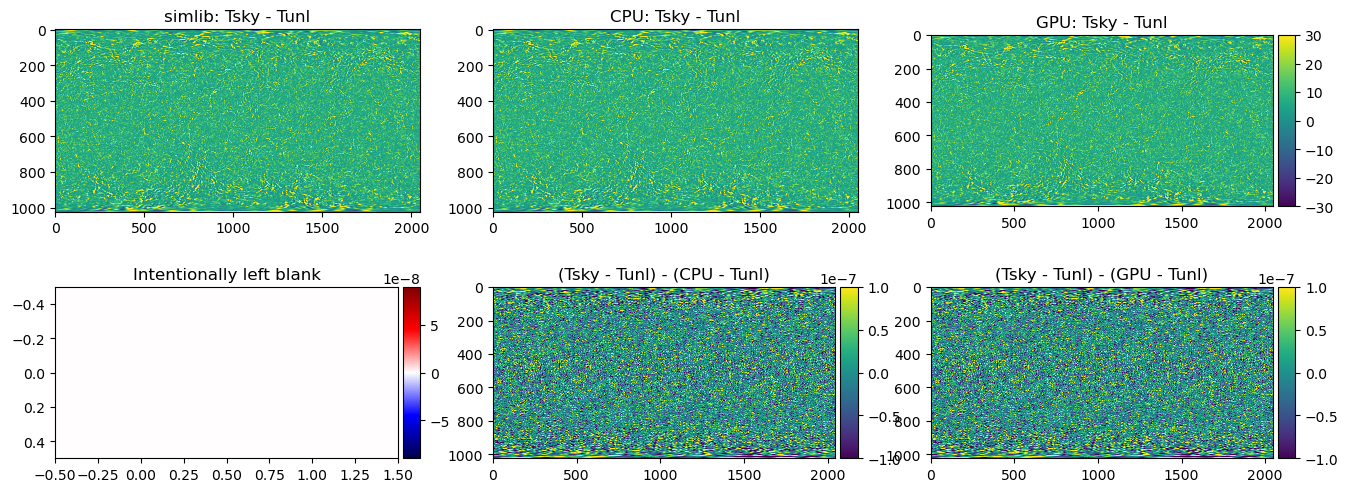

In [39]:
key = 'nuFFT'
# print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
Tsky = Tsky2
Tunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
resCPU = defres['CPU'][solverCPU][key].real
vmin, vmax = -3e1, 3e1
resCPU = defres['CPU'][solverCPU][key].real
resGPU = defres['GPU'][solverGPU][key][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow((Tsky-Tunlmap).reshape(lmax+1,-1).real, vmin=vmin, vmax=vmax)
ax[0,0].set_title('simlib: Tsky - Tunl')

ax[0,1].imshow((resCPU-Tunlmap).reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU: Tsky - Tunl')

im = ax[0,2].imshow((resGPU-Tunlmap).reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU: Tsky - Tunl')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow([[0,0]], vmin=-9e-8, vmax=9e-8, cmap='seismic')
ax[1,0].set_title('Intentionally left blank')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-Tunlmap)-(resCPU-Tunlmap)).reshape(lmax+1,-1), vmin=-1e-7, vmax=1e-7)
ax[1,1].set_title('(Tsky - Tunl) - (CPU - Tunl)')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-Tunlmap)-(resGPU-Tunlmap)).reshape(lmax+1,-1), vmin=-1e-7, vmax=1e-7)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('(Tsky - Tunl) - (GPU - Tunl)')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


"""differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'
"""